# Gravitational Waves Data Preprocessing 


<font size = 3> - In this data preprocessing file for gravitational wave detection, we first apply a whitening filter to remove noise from the raw signal. We then transform the signal into a spectrogram representation, which provides a visual representation of the signal's frequency content over time. The main implementation of this process was done with the help of the [GWpy](https://gwpy.github.io/) library. We also plot our date to acheivev more understanding! 

In [2]:
#Requiered libaries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries, TimeSeriesDict
from gwpy.plot import Plot
from glob import glob
import tensorflow as tf
import os 
import keras 
from tensorflow.keras.applications import MobileNetV2
from keras.losses import binary_crossentropy
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import tensorflow.keras.applications.mobilenet_v2 as mobilenet_v2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,roc_curve, auc

2023-04-22 00:08:19.289207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print(tf.config.list_physical_devices('GPU'))

[]


- ## Helper Functions For Preprocessing

In [4]:
#Function Purpose to Load npy Data given a path
def loadNpyData(path):
    data = np.load(path) 
    return data

In [5]:
#Function Purpose to Load CSV Data given a path
def loadCSVData(path):
    data = pd.read_csv(path)
    return data

In [6]:
#Function Purpose to return a labeled Data Frame of the Gravitational waves Time Series Data Frame
def createTSDataFrame(sample_data):
    labels = ['LIGO Hanford', 'LIGO Livingston', 'Virgo' ]
    df = pd.DataFrame(sample_data)
    df.index = labels
    return df 

In [7]:
#Function Purpose to return each time series object represented in the npy array, give Time Series Data
def read_ts_file(Time_Series_Data): 
    ts1 = TimeSeries(Time_Series_Data[0,:], sample_rate =2048)
    ts2 = TimeSeries(Time_Series_Data[1,:],sample_rate =2048)
    ts3 = TimeSeries(Time_Series_Data[2,:],sample_rate =2048)
    return  ts1, ts2, ts3

In [8]:
#Function to plot all 3 Time series individually
def plot_data(ts1, ts2, ts3):
    plot = Plot(ts1, ts2, ts3, separate=True, sharex=True, figsize=[17, 12])
    ax = plt.gca()   
    ax.set_xlim(0,2)  
    plot.axes[0].set_xlabel('Time [s]')
    plot.axes[0].set_ylabel('GW Amplitude [Strain]')
    plot.axes[1].set_xlabel('Time [s]')
    plot.axes[1].set_ylabel('GW Amplitude [Strain]')
    plot.axes[2].set_xlabel('Time [s]')
    plot.axes[2].set_ylabel('GW Amplitude [Strain]')
    plot.show()

In [9]:
#Ploting all time series in one plot
def plot_data_jointly(ts1, ts2, ts3):  
    plot = Plot(figsize=(15, 9))
    ax = plot.add_subplot(xscale='auto-gps')
    ax.plot(ts1, color='gwpy:ligo-hanford', label='LIGO-Hanford')
    ax.plot(ts2, color='gwpy:ligo-livingston', label='LIGO-Livingston')
    ax.plot(ts3, color='gwpy:virgo', label='Virgo')
    ax.set_xlim(0, 2)
    ax.set_ylabel('Gravitational Waves Amplitude')
    ax.set_xlabel('Time [s]')
    ax.set_title("Joint Plot of Time Series")
    ax.legend()
    plot.show()

- ## Loading Sample Data

In [10]:
#Loading sample data from given path
file_path = "../data/train/*/*/*/*"

train_path =glob(file_path)
path1_signal = train_path[100] #Signal
path_no_signal = train_path[105] #No Signal

#Loading 2D Npy Arrays and storing into variable
sample_data_signal = loadNpyData(path1_signal)
sample_no_signal = loadNpyData(path_no_signal)

#Showing an example file
df = pd.DataFrame(sample_data_signal)
df

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,1.324145e-20,1.369946e-20,1.387562e-20,1.436595e-20,1.461748e-20,1.476490e-20,1.518756e-20,1.541880e-20,1.581288e-20,1.596647e-20,...,-1.622702e-21,-1.571701e-21,-1.504922e-21,-1.464702e-21,-1.149852e-21,-1.164090e-21,-7.543436e-22,-7.881004e-22,-3.182185e-22,-3.680239e-22
1,-4.711470e-21,-5.024133e-21,-4.973088e-21,-5.151691e-21,-5.199369e-21,-5.583250e-21,-5.623010e-21,-5.721736e-21,-6.042443e-21,-5.988219e-21,...,-6.402754e-21,-6.739418e-21,-7.189226e-21,-7.683984e-21,-7.909586e-21,-8.013539e-21,-8.225965e-21,-8.687971e-21,-9.073340e-21,-9.227119e-21
2,1.459835e-21,1.523104e-21,1.169637e-21,1.182225e-21,1.218971e-21,8.286134e-22,1.131700e-21,9.021335e-22,8.045017e-22,8.179087e-22,...,2.146530e-21,1.504071e-21,1.540953e-21,1.683824e-21,1.637962e-21,1.054275e-21,1.723198e-21,1.164651e-21,1.623760e-21,1.081185e-21


In [11]:
path_no_signal

'../data/train/9/9/9/9999461966.npy'

In [12]:
#Storing each timeseries (from each device), for both timeseries with a signal and no signal
ts_signal1,  ts_signal2,  ts_signal3 = read_ts_file(sample_data_signal)
ts_no_signal1,  ts_no_signal2,  ts_no_signal3 = read_ts_file(sample_no_signal)

/Users/Robin1/opt/anaconda3/envs/COMP_542/lib/python3.9/site-packages/gwpy/plot/plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


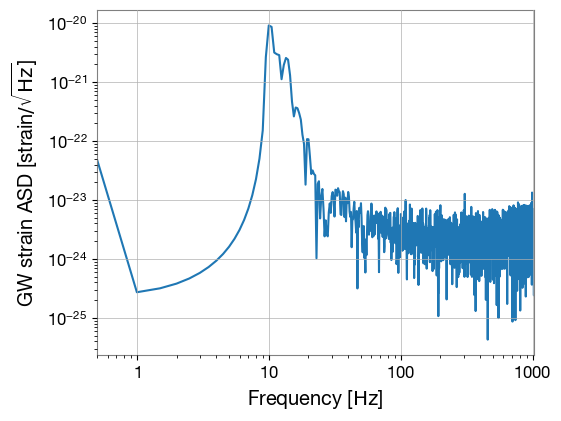

In [13]:
#FFT and plot of data after Calculatin=g the FFT
spectrum = ts_signal1.asd(2)
plot = spectrum.plot()
ax = plot.gca()
ax.set_xlim()
ax.set_ylabel(r'GW strain ASD [strain$/\sqrt{\mathrm{Hz}}$]')
plot.show()


- ##  Ploting Time Series Sample Data

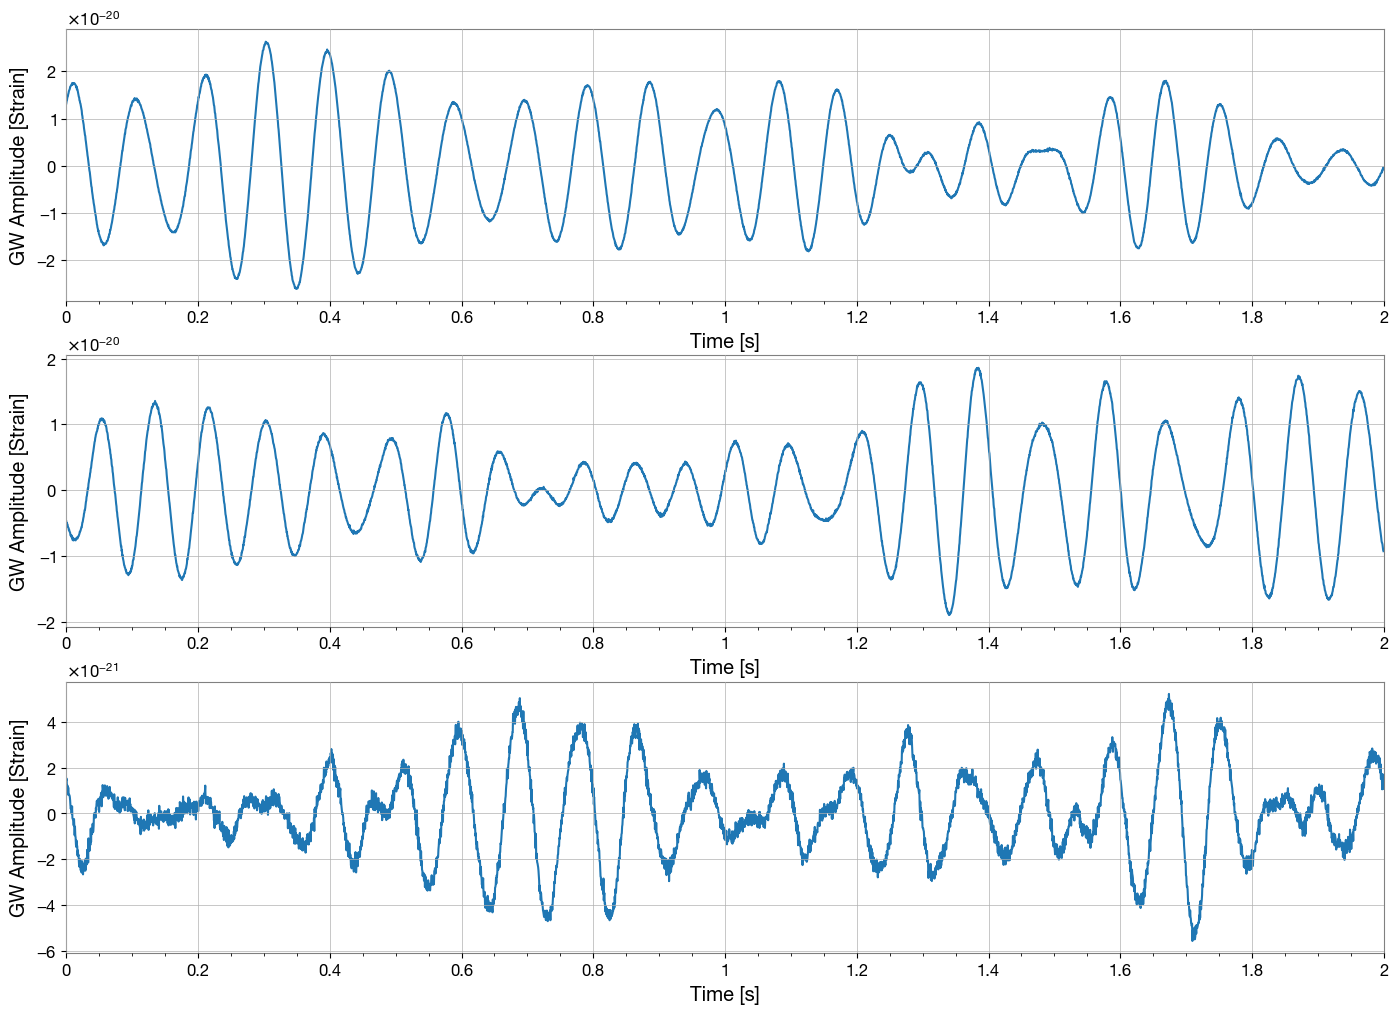

In [14]:
#ploting time Series with signal
plot_data(ts_signal1,  ts_signal2,  ts_signal3)

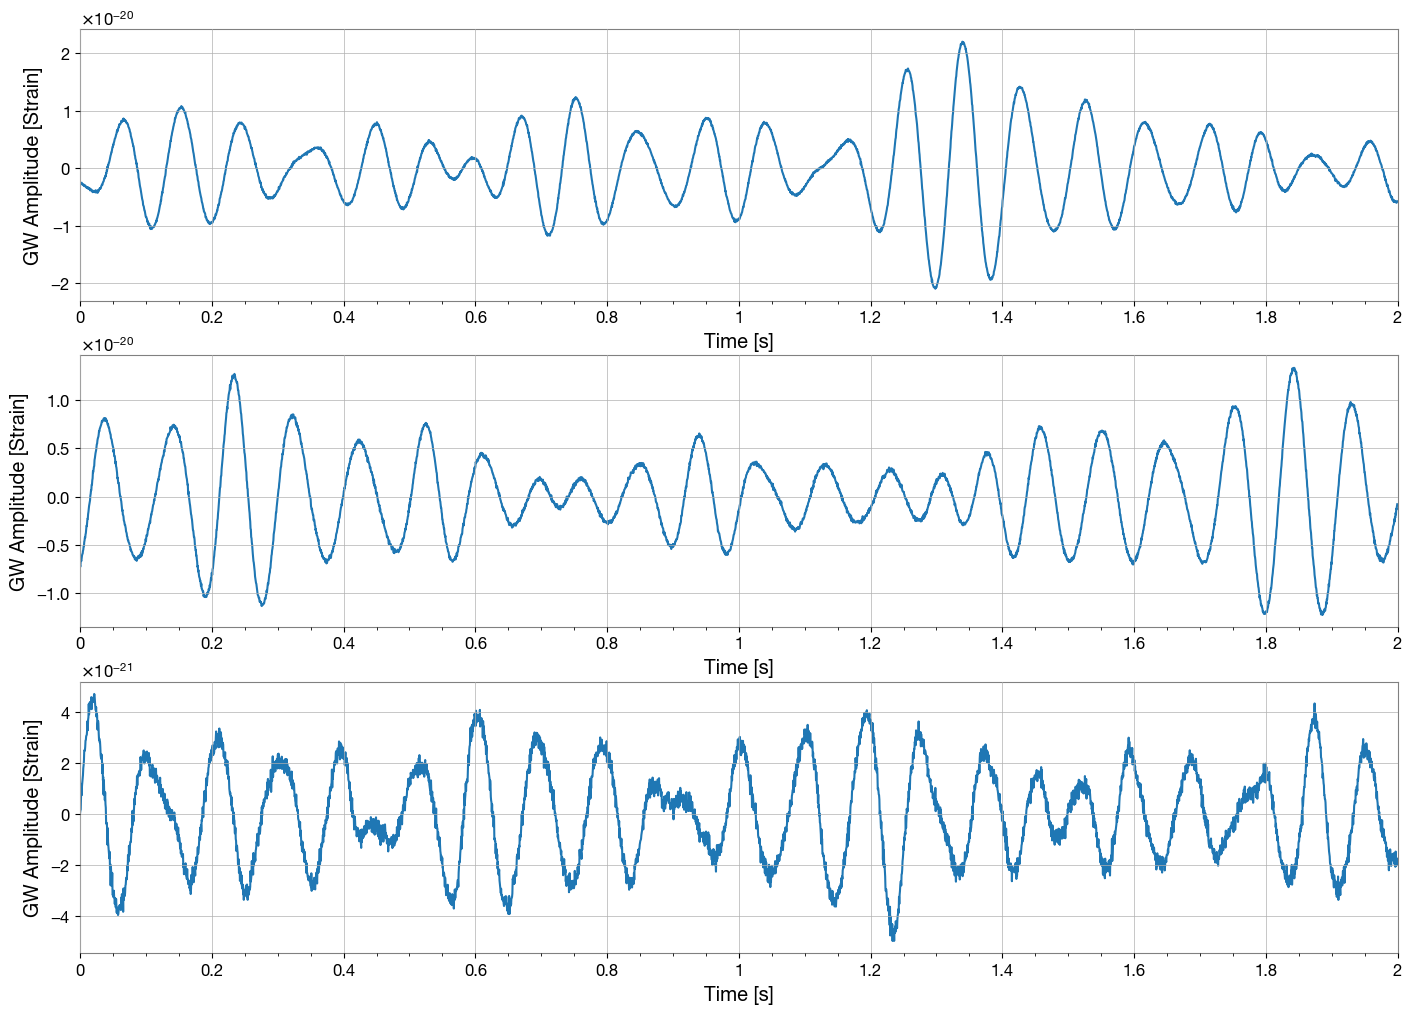

In [15]:
#ploting time Series without a signal
plot_data(ts_no_signal1,  ts_no_signal2,  ts_no_signal3)

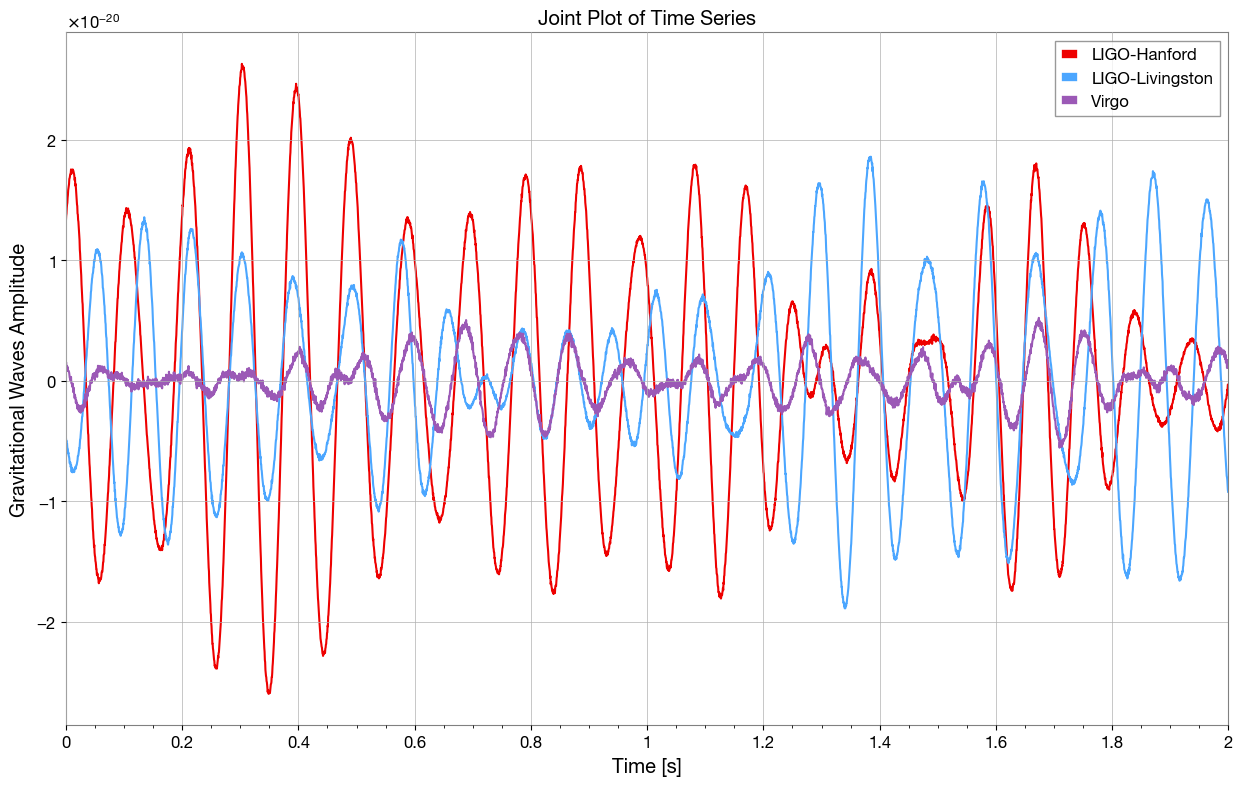

In [16]:
#Joint plot of time series with a signal
plot_data_jointly(ts_signal1,  ts_signal2,  ts_signal3)

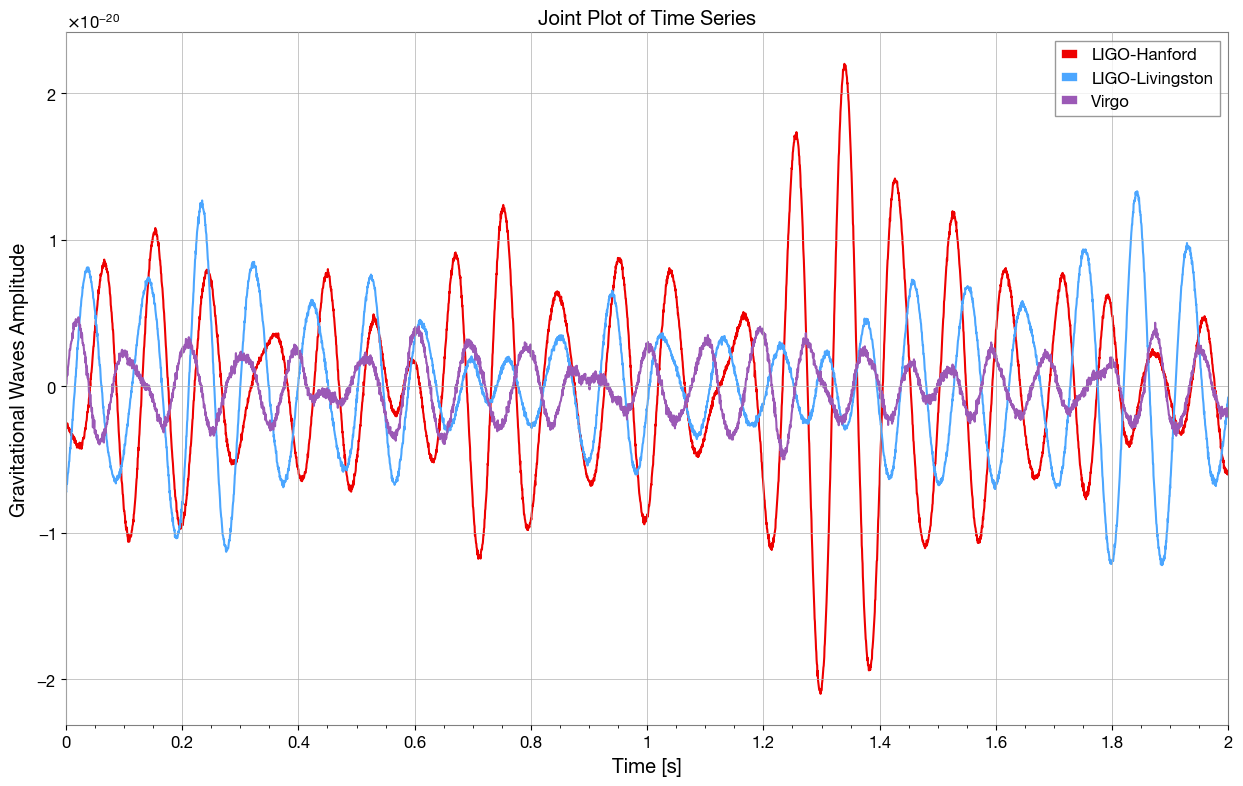

In [17]:
#Joint plot of time series without a signal
plot_data_jointly(ts_no_signal1,  ts_no_signal2,  ts_no_signal3)

[Text(0.5, 1.0, 'Not Whiten')]

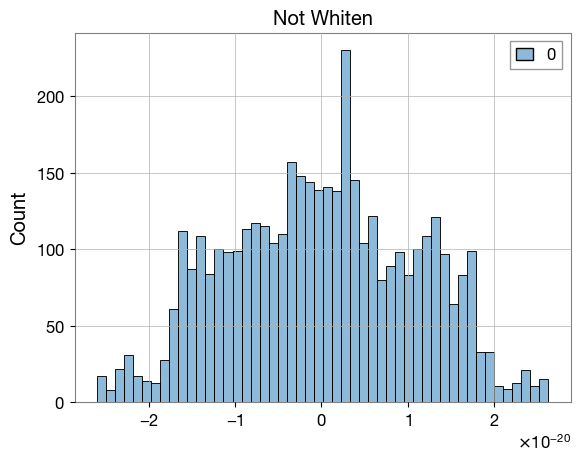

In [18]:
#ploting to check the distribution of the Data
ts_signal1_df = pd.DataFrame(ts_signal1)
sns.histplot(ts_signal1_df, bins =50).set(title ="Not Whiten")

- <font size = 4> We observe there is no visual diffrence, between a timeseris file with or withouth a signal.

- ## Filtering Methods

In [19]:
#Function to whiten the TimeSeries data
def filterTimeSeries(ts1,ts2,ts3):
    transitionRegion = 0.2
    ts1_whiten = ts1.whiten(2, window=('tukey',transitionRegion))
    ts2_whiten = ts2.whiten(2, window=('tukey',transitionRegion))
    ts3_whiten = ts3.whiten(2, window=('tukey',transitionRegion))
   
    return ts1_whiten ,ts2_whiten,  ts3_whiten

In [20]:
#Function to retrun the constant Q transform give GW time-series data
def qTransform(ts1,ts2,ts3):
    spect1 = ts1.q_transform(qrange=(16,32), frange=(30,400), logf=True, whiten=False)
    spect2 = ts2.q_transform(qrange=(16,32), frange=(30,400), logf=True, whiten=False)
    spect3 = ts3.q_transform(qrange=(16,32), frange=(30,400), logf=True, whiten=False)
    return spect1,spect2,spect3

In [21]:
#Function To Generate And Plot the Q-Transform of the Data
def qSpectrogramPlot(qspecgram):
    plot = qspecgram.plot(figsize=[20, 15])
    ax = plot.gca()
    ax.set_xscale('seconds')
    ax.set_yscale('log')
    ax.set_ylabel('Frequency [Hz]')
    ax.grid(True, axis='y', which='both')
    ax.colorbar(cmap='viridis', label='Normalized energy')
    plot.show()
   

- ## Whitening

In [22]:
#Storing Whiten Time Series In Variables, and Ploting
ts1_whiten, ts2_whiten, ts3_whiten = filterTimeSeries(ts_signal1,ts_signal2,ts_signal3)

/Users/Robin1/opt/anaconda3/envs/COMP_542/lib/python3.9/site-packages/gwpy/plot/plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


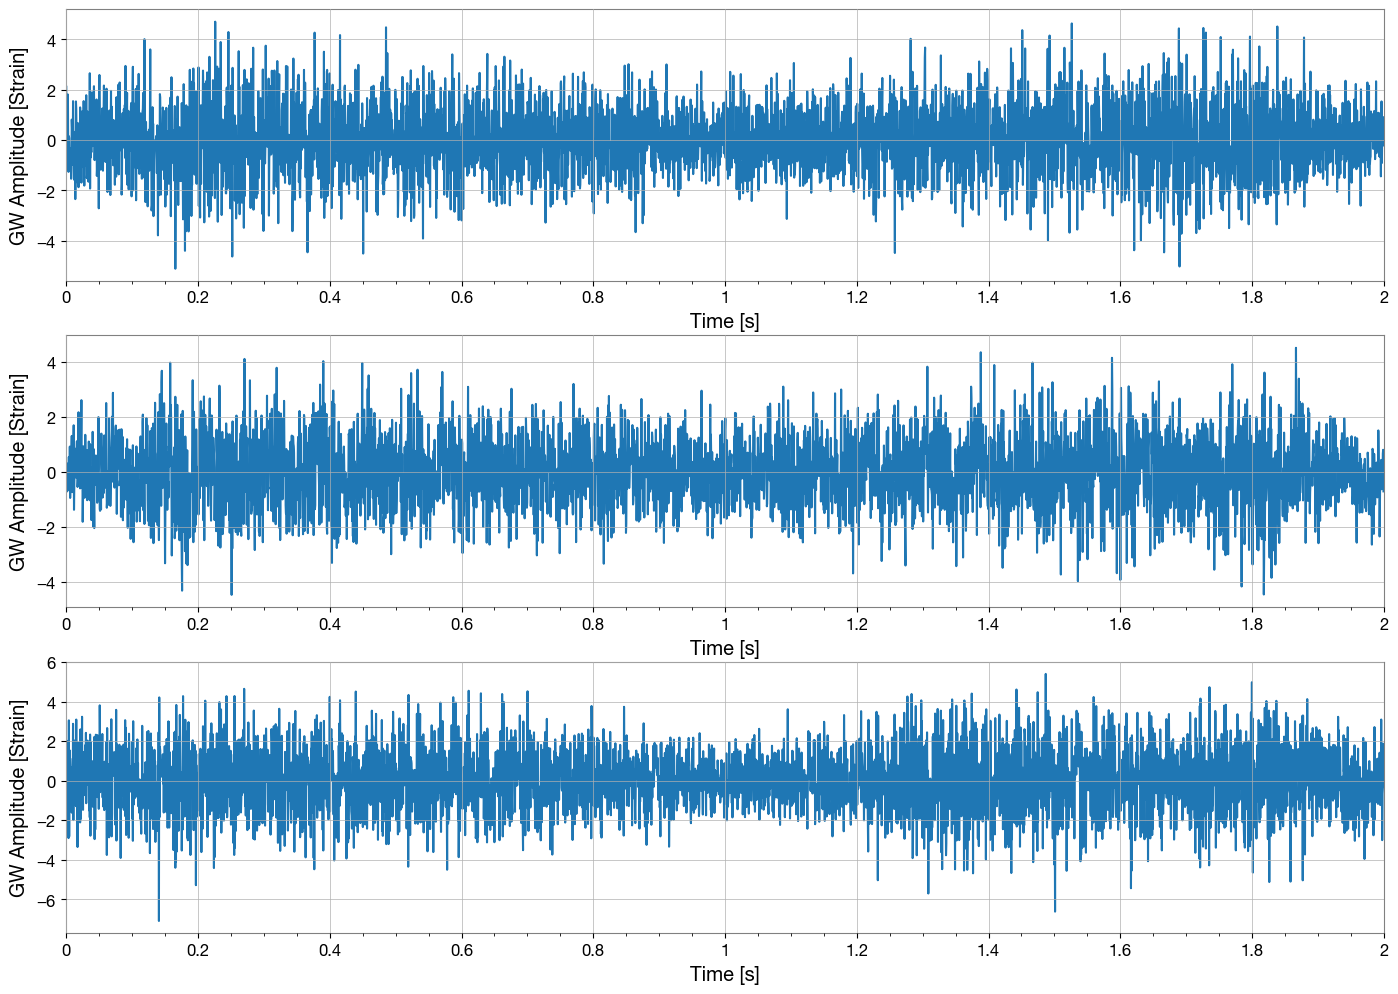

In [23]:
#Ploting the data after a Whiten filter was applied to data with a signal
plot_data(ts1_whiten, ts2_whiten,ts3_whiten)

[Text(0.5, 1.0, 'Time Series Whiten')]

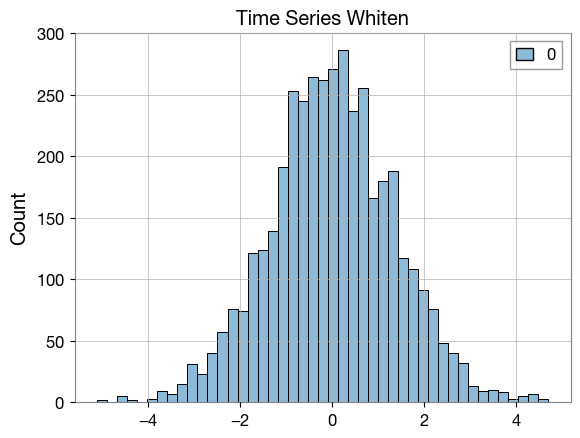

In [24]:
#ploting to check the distribution of the Data
ts1_whiten_df = pd.DataFrame(ts1_whiten)
sns.histplot(ts1_whiten_df).set(title = "Time Series Whiten")

/Users/Robin1/opt/anaconda3/envs/COMP_542/lib/python3.9/site-packages/gwpy/plot/plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


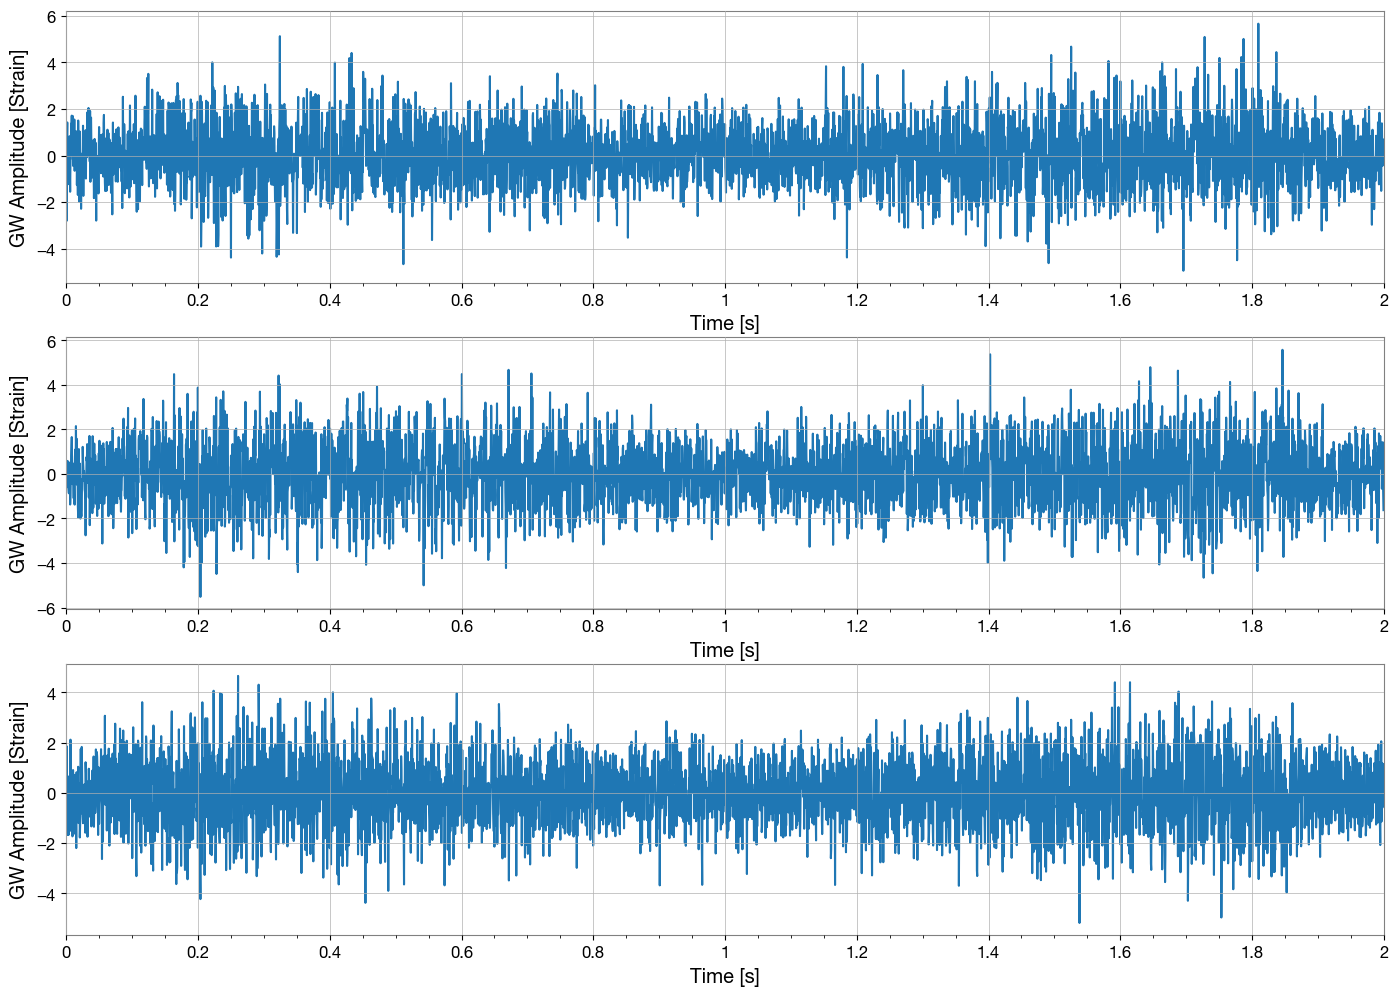

In [25]:
#Storing Whiten Time Series In Variables, and Ploting, for file without signal
ts1_no_whiten, ts2_no_whiten, ts3_no_whiten = filterTimeSeries(ts_no_signal1,ts_no_signal2,ts_no_signal3)
plot_data(ts1_no_whiten, ts2_no_whiten, ts3_no_whiten)

- ## Q transform

/Users/Robin1/opt/anaconda3/envs/COMP_542/lib/python3.9/site-packages/gwpy/plot/plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


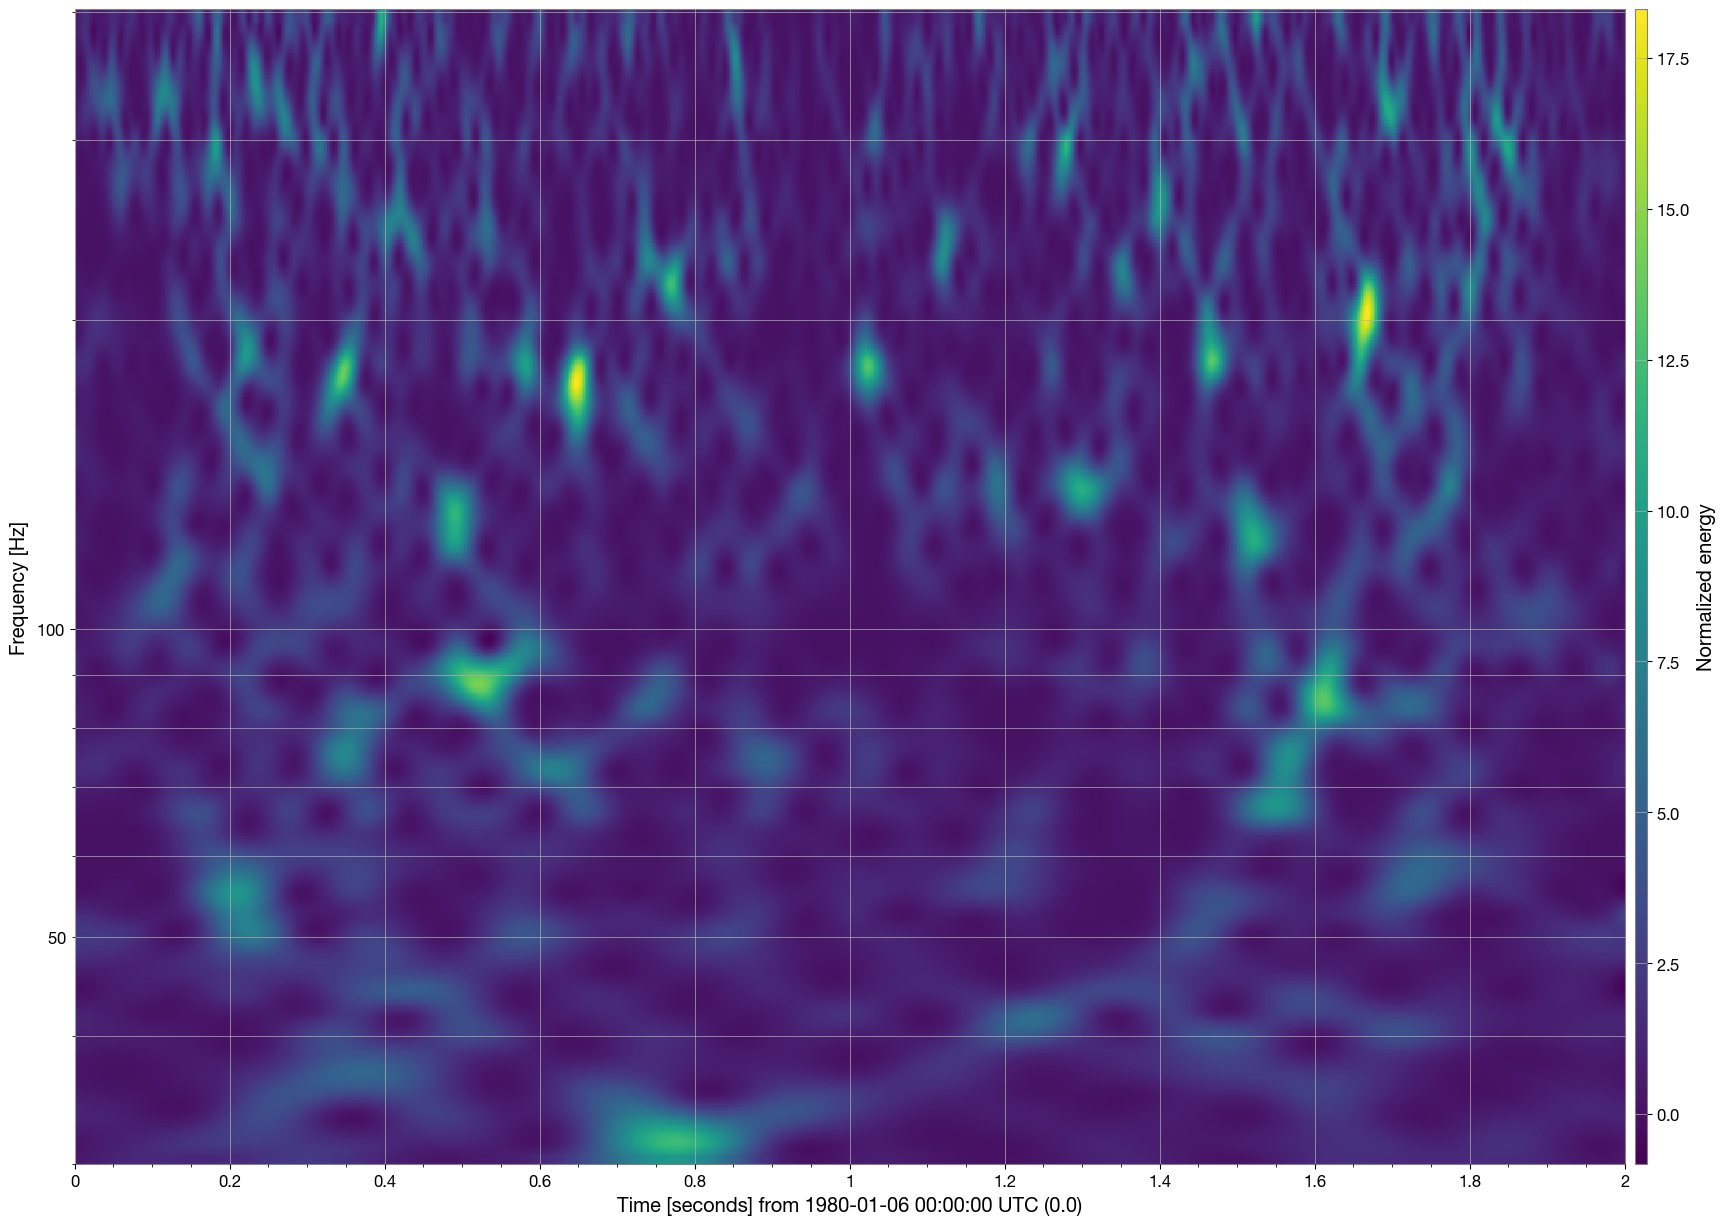

In [26]:
# Q transform Spectrogram Gravitatntional Wave time series with a signal
qspecgram_signal1,qspecgram_signal2,qspecgram_signal3 =qTransform(ts1_whiten,ts2_whiten,ts3_whiten)
qSpectrogramPlot(qspecgram_signal1)

In [27]:
# Applying Filtertin and Generating Q Transform of data withjout a Signal Present
ts1_no_whiten, ts2_no_whiten, ts3_no_whiten = filterTimeSeries(ts_no_signal1,  ts_no_signal2,  ts_no_signal3)

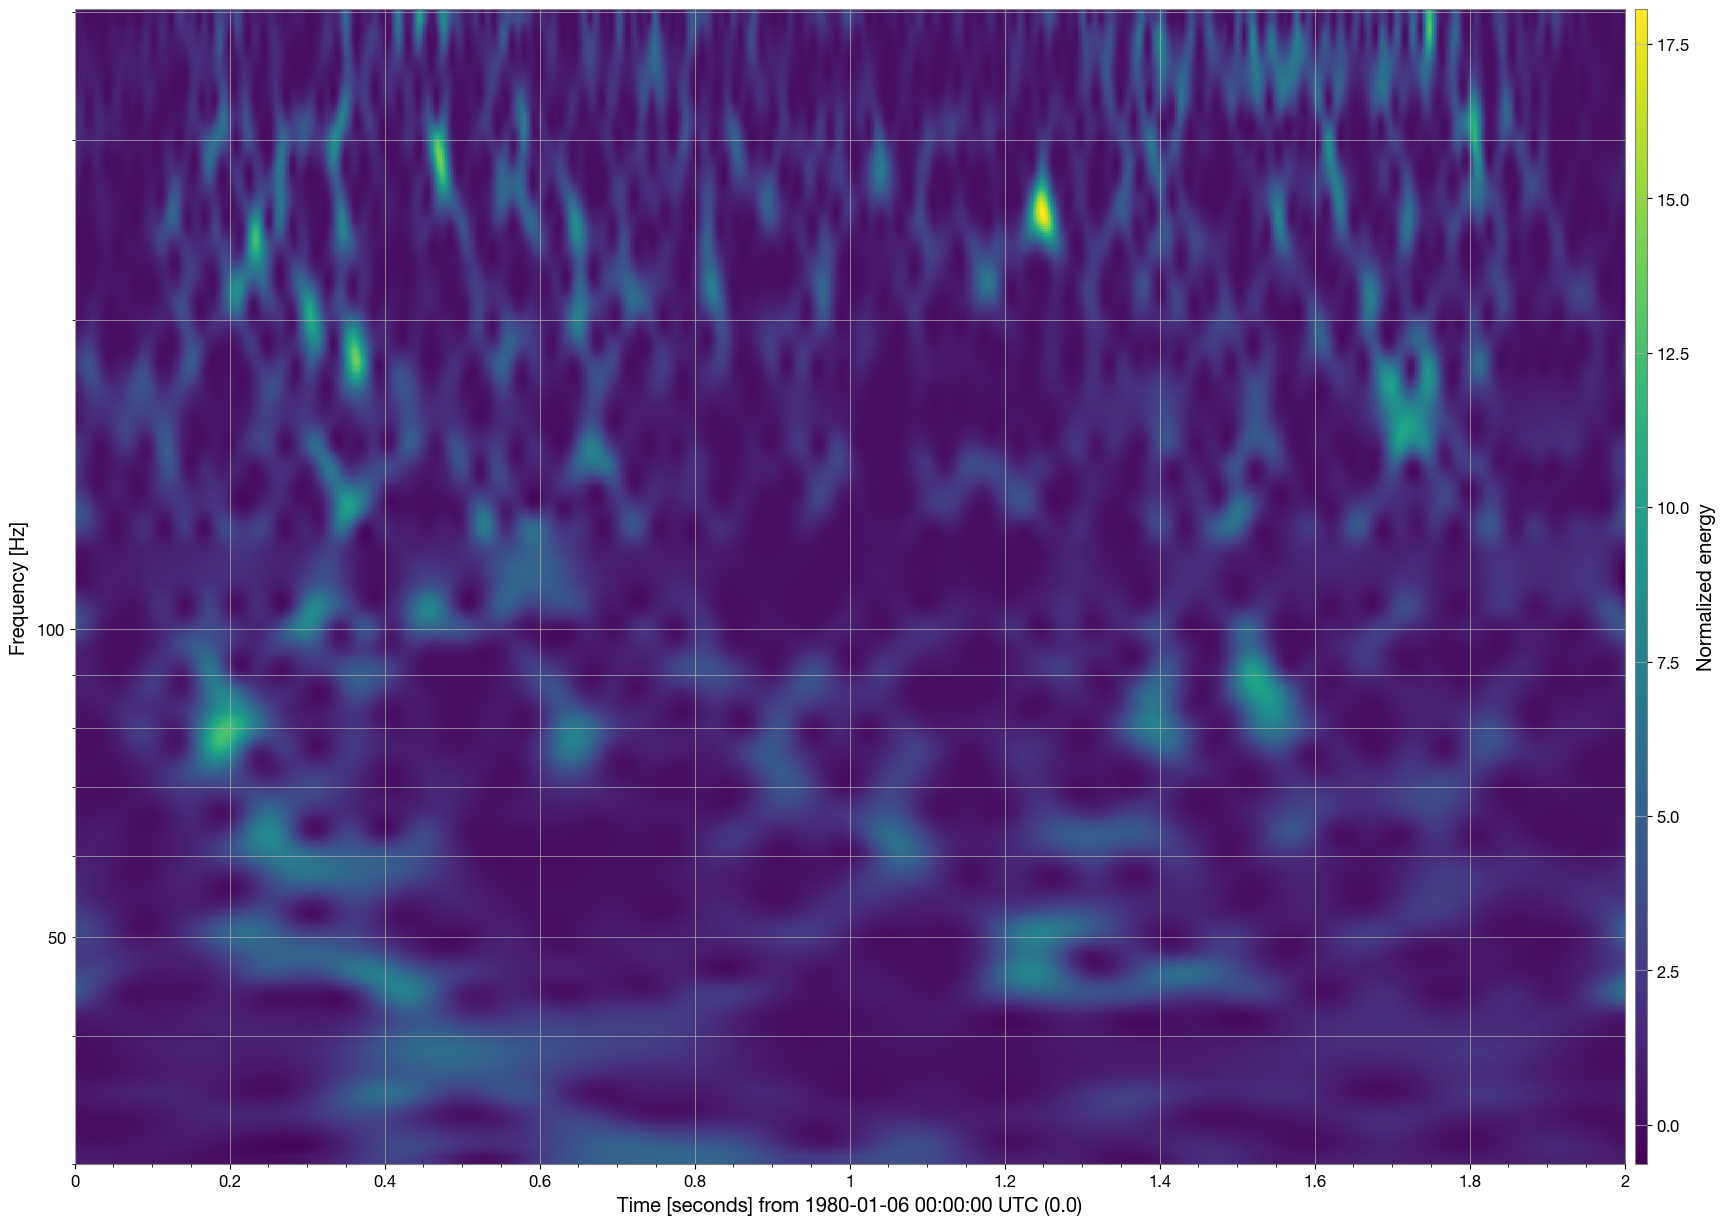

In [28]:
# Q transform Spectrogram Gravitatntional Wave time series without a signal
qspecgram_no_signal1,qspecgram_no_signal2,qspecgram_no_signal3 =qTransform(ts1_no_whiten, ts2_no_whiten, ts3_no_whiten)
qSpectrogramPlot(qspecgram_no_signal2)

In [29]:
qspecgram_signal1.shape

(1000, 500)

In [30]:
qspecgram_signal2.shape

(1000, 500)

In [31]:
qspecgram_signal3.shape

(1000, 500)

In [32]:
#Stacking all 3 spectograms
stacked_spectrograms = np.stack((qspecgram_signal1, qspecgram_signal2, qspecgram_signal3), axis=-1)
stacked_spectrograms.shape

(1000, 500, 3)

- ## Training Label Data Analysis

In [33]:
#Loading training Labels File
labels_file = "../data/training_labels.csv"
training_labels = pd.read_csv(labels_file)

In [34]:
#Calling Training Labels
training_labels

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1
...,...,...
559995,ffff9a5645,1
559996,ffffab0c27,0
559997,ffffcf161a,1
559998,ffffd2c403,0


<AxesSubplot: xlabel='target', ylabel='count'>

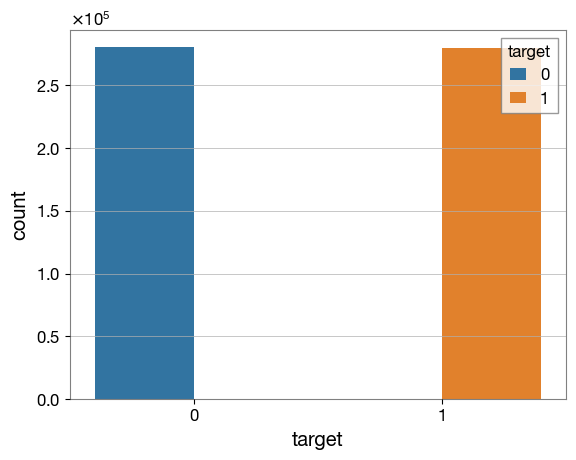

In [35]:
#Plotning a count plot to chck if training labels are balanced
sns.countplot(data = training_labels,x= "target", hue = "target")

- <font size = 4> We observe that the Training labels data set is balanced 

In [36]:
#Chacking Training Labels For Null Valulese
training_labels.isnull().sum()

id        0
target    0
dtype: int64

- <font size = 4> We observe that there are no null values in our data set

In [37]:
# Creating a DataFrame with file paths
path_df = pd.DataFrame({'path': train_path})
path_df.head()

,path
0,../data/train/9/9/9/999ad4156d.npy
1,../data/train/9/9/9/999b57891b.npy
2,../data/train/9/9/9/999b4f080f.npy
3,../data/train/9/9/9/999f7e72ad.npy
4,../data/train/9/9/9/999a097c74.npy


In [38]:
# Extracting the IDs from the file paths
path_df['id'] = path_df['path'].apply(lambda x: x.split('/')[-1].replace(".npy",""))
path_df.head()

,path,id
0,../data/train/9/9/9/999ad4156d.npy,999ad4156d
1,../data/train/9/9/9/999b57891b.npy,999b57891b
2,../data/train/9/9/9/999b4f080f.npy,999b4f080f
3,../data/train/9/9/9/999f7e72ad.npy,999f7e72ad
4,../data/train/9/9/9/999a097c74.npy,999a097c74


In [39]:
# Merging the two DataFrames on the 'id' column
merged_df = pd.merge(path_df, training_labels, on='id')
merged_df.head()

,path,id,target
0,../data/train/9/9/9/999ad4156d.npy,999ad4156d,0
1,../data/train/9/9/9/999b57891b.npy,999b57891b,1
2,../data/train/9/9/9/999b4f080f.npy,999b4f080f,0
3,../data/train/9/9/9/999f7e72ad.npy,999f7e72ad,1
4,../data/train/9/9/9/999a097c74.npy,999a097c74,1


In [40]:
#Creating a DF that maps file paths to specific label
#Mapping file_name -> label
label_map = {}
for i, row in  training_labels.iterrows():
    label_map[row[0]] = row[1]

len(label_map)

560000

## Data Input Pipeline

- <font size =4> Functions

In [41]:
#Image Shape
IMAGE_SHAPE = (224, 244)

In [42]:
#Function purpose to load the data and, generate the spectograms and stack the 3 spectograms
def load_and_stack(path):
    data = np.load(path.numpy().decode("utf-8"))
    ts1, ts2, ts3 =  read_ts_file(data)
    whiten1, whiten2, whiten3 = filterTimeSeries(ts1, ts2, ts3) #Applying whitening filter
    spect1, spect2, spect3 = qTransform(whiten1, whiten2, whiten3)
    stacked_spectrograms = np.stack((spect1, spect2, spect3), axis=-1)
    resized_spectrograms = tf.image.resize(stacked_spectrograms, size=IMAGE_SHAPE)
    
    # Preprocessing the image data using the MobileNetV2 preprocessing function to set the range from [-1,1]
    preprocessed_spectrograms = mobilenet_v2.preprocess_input(resized_spectrograms)
    
    return preprocessed_spectrograms

In [43]:
#Function purpose to read npy file and return a tensor object 
def process_file(file_path,label):
    tensor = tf.py_function(
        func=load_and_stack,
        inp=[file_path],
        Tout=tf.float32,
    )
    return tensor,tf.reshape(label, [-1, 1])

- <font size =4> Pipeline

In [44]:
#Createing Dataset with path and Labels, casting the labels to 8 bit integers for memory efficency
dataset = tf.data.Dataset.from_tensor_slices((merged_df['path'], tf.cast(merged_df['target'], tf.uint8)))
len(dataset)

560000

In [45]:
#Displaying contents of data_set
for img in dataset.take(5):
    print(img)

(<tf.Tensor: shape=(), dtype=string, numpy=b'../data/train/9/9/9/999ad4156d.npy'>, <tf.Tensor: shape=(), dtype=uint8, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'../data/train/9/9/9/999b57891b.npy'>, <tf.Tensor: shape=(), dtype=uint8, numpy=1>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'../data/train/9/9/9/999b4f080f.npy'>, <tf.Tensor: shape=(), dtype=uint8, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'../data/train/9/9/9/999f7e72ad.npy'>, <tf.Tensor: shape=(), dtype=uint8, numpy=1>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'../data/train/9/9/9/999a097c74.npy'>, <tf.Tensor: shape=(), dtype=uint8, numpy=1>)


In [46]:
DATASET_SIZE = len(dataset)
train_size = int(0.8 * DATASET_SIZE)
validation_size = int(0.1 * DATASET_SIZE)
testing_size = int(0.1 * DATASET_SIZE)

# Spliting the dataset into training, validation, and testing sets
train_ds = dataset.take(train_size)
validation_ds = dataset.skip(train_size).take(validation_size)
testing_ds = dataset.skip(train_size + validation_size).take(testing_size)

print("Size of Dataset:", DATASET_SIZE)
print("Size of Training set:", len(train_ds))
print("Size of Validation set:", len(validation_ds))
print("Size of Testing set:", len(testing_ds))

Size of Dataset: 560000
Size of Training set: 448000
Size of Validation set: 56000
Size of Testing set: 56000


In [47]:
#Using .map to create a datasets of the stacked qtransform spectograms for training
train_ds = train_ds.map(process_file, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds.prefetch(DATASET_SIZE-train_size)

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(1, 1), dtype=tf.uint8, name=None))>

In [48]:
#Using .map to create a datasets of the stacked qtransform spectograms for validation
validation_ds = validation_ds.map(process_file, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
validation_ds =validation_ds.shuffle(buffer_size=100)
validation_ds.prefetch(DATASET_SIZE-validation_size)

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(1, 1), dtype=tf.uint8, name=None))>

In [49]:
#Using .map to create a datasets of the stacked qtransform spectograms for testing
testing_ds = testing_ds.map(process_file, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
testing_ds = testing_ds.shuffle(buffer_size=100)
testing_ds.prefetch(DATASET_SIZE-testing_size)

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(1, 1), dtype=tf.uint8, name=None))>

In [50]:
#Printing file from our training dataset
for file, label in train_ds.take(1):
    print("File:" ,file)
    print("Label:" ,label)

File: tf.Tensor(
[[[-0.9904209  -0.9941841  -0.98818964]
  [-0.9904209  -0.9941841  -0.98818964]
  [-0.9887968  -0.9950733  -0.9890335 ]
  ...
  [-0.9996722  -0.9982871  -0.9875437 ]
  [-0.999799   -0.9983337  -0.9877363 ]
  [-0.999799   -0.9983337  -0.9877363 ]]

 [[-0.98976785 -0.99315214 -0.9884638 ]
  [-0.98976785 -0.99315214 -0.9884638 ]
  [-0.98803246 -0.9939576  -0.9892312 ]
  ...
  [-0.9917616  -0.9963888  -0.9696989 ]
  [-0.9916991  -0.9964481  -0.9687322 ]
  [-0.9916991  -0.9964481  -0.9687322 ]]

 [[-0.98937726 -0.992006   -0.98918146]
  [-0.98937726 -0.992006   -0.98918146]
  [-0.9875791  -0.99272233 -0.9898541 ]
  ...
  [-0.99715453 -0.99274594 -0.9680871 ]
  [-0.9975097  -0.99280393 -0.96742046]
  [-0.9975097  -0.99280393 -0.96742046]]

 ...

 [[-0.99302787 -0.9967019  -0.9893212 ]
  [-0.99302787 -0.9967019  -0.9893212 ]
  [-0.9918797  -0.99769557 -0.99026984]
  ...
  [-0.9938133  -0.9907903  -0.9948398 ]
  [-0.99422675 -0.99068445 -0.994649  ]
  [-0.99422675 -0.99068445 

In [51]:
#Printing file from our validation dataset
for file, label in validation_ds.take(1):
    print("File:" ,file) 
    print("Label:" ,label)

File: tf.Tensor(
[[[-0.99985373 -0.9988248  -0.9867168 ]
  [-0.99985373 -0.9988248  -0.9867168 ]
  [-0.9991046  -0.99775535 -0.9836956 ]
  ...
  [-0.9497286  -0.9894831  -0.9662561 ]
  [-0.9501781  -0.9891019  -0.96317345]
  [-0.9501781  -0.9891019  -0.96317345]]

 [[-0.9999175  -0.9982779  -0.9865929 ]
  [-0.9999175  -0.9982779  -0.9865929 ]
  [-0.99884343 -0.99718696 -0.98397374]
  ...
  [-0.9931505  -0.99290437 -1.0008949 ]
  [-0.9916856  -0.99213564 -0.99955046]
  [-0.9916856  -0.99213564 -0.99955046]]

 [[-0.9999603  -0.99752516 -0.9864718 ]
  [-0.9999603  -0.99752516 -0.9864718 ]
  [-0.9986203  -0.99643356 -0.9842526 ]
  ...
  [-0.9951636  -0.9858878  -0.998294  ]
  [-0.9947106  -0.9859363  -0.9990698 ]
  [-0.9947106  -0.9859363  -0.9990698 ]]

 ...

 [[-0.999797   -0.9993953  -0.98703974]
  [-0.999797   -0.9993953  -0.98703974]
  [-0.9997941  -0.99858    -0.98261374]
  ...
  [-0.999985   -0.9936732  -0.9891527 ]
  [-0.999329   -0.99364936 -0.9888172 ]
  [-0.999329   -0.99364936 

In [52]:
#Printing file from our testing dataset
for file, label in testing_ds.take(1):
    print("File:" ,file) 
    print("Label:" ,label)

File: tf.Tensor(
[[[-0.98870015 -0.93480915 -0.99187624]
  [-0.98870015 -0.93480915 -0.99187624]
  [-0.98866165 -0.93962824 -0.9919311 ]
  ...
  [-0.9919715  -0.97558296 -0.99869734]
  [-0.9914021  -0.97490203 -0.9988493 ]
  [-0.9914021  -0.97490203 -0.9988493 ]]

 [[-0.98904735 -0.93477744 -0.99227107]
  [-0.98904735 -0.93477744 -0.99227107]
  [-0.98853356 -0.93917537 -0.99257326]
  ...
  [-0.9920981  -0.9969727  -0.9998642 ]
  [-0.99167216 -0.9968065  -0.99982125]
  [-0.99167216 -0.9968065  -0.99982125]]

 [[-0.98955697 -0.9365444  -0.9926794 ]
  [-0.98955697 -0.9365444  -0.9926794 ]
  [-0.988647   -0.9402428  -0.9932334 ]
  ...
  [-0.991746   -0.99718964 -0.9994034 ]
  [-0.9912661  -0.9969876  -0.9994254 ]
  [-0.9912661  -0.9969876  -0.9994254 ]]

 ...

 [[-0.9883161  -0.9436215  -0.99071395]
  [-0.9883161  -0.9436215  -0.99071395]
  [-0.989714   -0.9485656  -0.9900351 ]
  ...
  [-0.99852586 -0.9967696  -0.99985677]
  [-0.9984119  -0.9970997  -0.99979156]
  [-0.9984119  -0.9970997  

## MobileNet Model

In [53]:
BATCH_SIZE=4

In [54]:
#.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE)
ds_training_dataset=train_ds.batch(BATCH_SIZE)
ds_validation_dataset=validation_ds.batch(BATCH_SIZE)
ds_testing_dataset=testing_ds.batch(BATCH_SIZE)

In [63]:
print("Number of batches in train: ", ds_training_dataset.cardinality().numpy())
print("Number of batches in validation: ", ds_validation_dataset.cardinality().numpy())
print("Number of batches in test: ", ds_testing_dataset.cardinality().numpy())

Number of batches in train:  112000
Number of batches in validation:  14000
Number of batches in test:  14000


In [90]:
# Defining the base model
model = MobileNetV2(input_shape=(224, 224, 3), include_top=False)
model.trainable = False

In [91]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [65]:
# Adding average_layer and 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

#Creating the final model
model = tf.keras.Sequential([
    model,
    global_average_layer,
    prediction_layer,
])

In [66]:
# Compiling the final model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [89]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [67]:
# Training the model
epochs = 7
history = model.fit(ds_training_dataset, epochs=epochs, validation_data=ds_validation_dataset)

Epoch 1/7
112000/112000 [==============================] - 59240s 528ms/step - loss: 0.5849 - accuracy: 0.6717 - val_loss: 0.6579 - val_accuracy: 0.6635
Epoch 2/7
112000/112000 [==============================] - 58702s 523ms/step - loss: 0.5786 - accuracy: 0.6784 - val_loss: 0.5944 - val_accuracy: 0.6856
Epoch 3/7
112000/112000 [==============================] - 59146s 527ms/step - loss: 0.5772 - accuracy: 0.6796 - val_loss: 0.5690 - val_accuracy: 0.6733
Epoch 4/7
112000/112000 [==============================] - 58711s 523ms/step - loss: 0.5774 - accuracy: 0.6796 - val_loss: 0.5586 - val_accuracy: 0.6947
Epoch 5/7
112000/112000 [==============================] - 58725s 523ms/step - loss: 0.5765 - accuracy: 0.6808 - val_loss: 0.5596 - val_accuracy: 0.6943
Epoch 6/7
112000/112000 [==============================] - 60391s 538ms/step - loss: 0.5768 - accuracy: 0.6800 - val_loss: 0.6004 - val_accuracy: 0.6849
Epoch 7/7
112000/112000 [==============================] - 58905s 525ms/step - los

In [68]:
#Path to save model
model_dir = '../model'

# Saving the model
model.save(model_dir)

INFO:tensorflow:Assets written to: ../model/assets


INFO:tensorflow:Assets written to: ../model/assets


In [69]:
# Evaluating the model
loss, accuracy = model.evaluate(ds_testing_dataset)
print('Test accuracy:', accuracy)

14000/14000 [==============================] - 6783s 484ms/step - loss: 0.6026 - accuracy: 0.6343
Test accuracy: 0.6342678666114807


In [70]:
#Printing the training history
print(history.history)

{'loss': [0.5848581790924072, 0.5785802006721497, 0.5772178173065186, 0.5773577094078064, 0.5765038728713989, 0.5767619609832764, 0.5767108798027039], 'accuracy': [0.6717098355293274, 0.6783571243286133, 0.6796048879623413, 0.679562509059906, 0.6807611584663391, 0.6800178289413452, 0.680620551109314], 'val_loss': [0.6578676104545593, 0.5944188833236694, 0.5690315961837769, 0.5586454272270203, 0.5595794916152954, 0.6004425883293152, 0.6069798469543457], 'val_accuracy': [0.6634643077850342, 0.6856428384780884, 0.6732678413391113, 0.6946964263916016, 0.6942856907844543, 0.6849464178085327, 0.6272500157356262]}


- <font size = 4> Performance Plots

In [85]:
### function purpose to plot the Loss of training
def plot_model_loss(history):
    fig = plt.figure()
    plt.plot(history.history['loss'], color='teal', label='train_loss')
    plt.plot(history.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy Score")
    plt.show()

In [86]:
#function purpose to plot the Accuracy of training
def plot_model_accuracy(history):
    fig = plt.figure()
    plt.plot(history.history['accuracy'], color='teal', label='train_accuracy')
    plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy Score")
    plt.show()

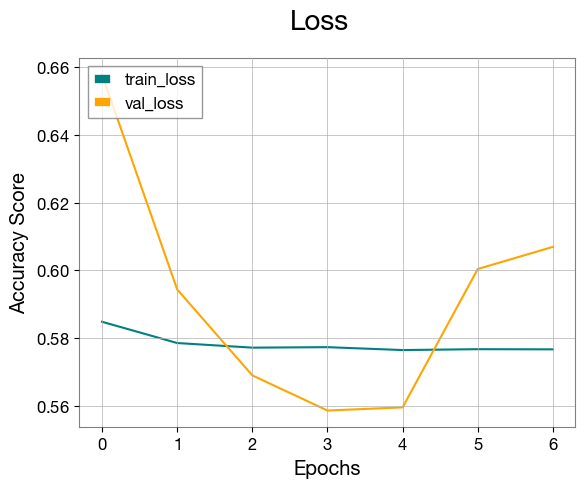

In [87]:
#Ploting the model loss
plot_model_loss(history)

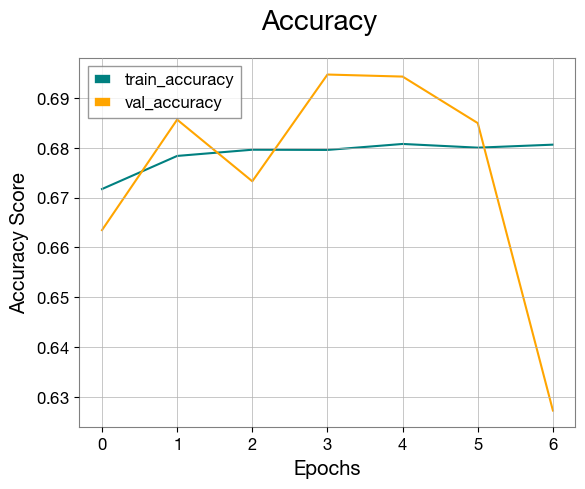

In [88]:
#ploting the models accuracy
plot_model_accuracy(history)

## Model Evaluation

In [75]:
#Function Purpose to Plot the Confusion Matrix 
def plot_confusion_matrix(y_test, y_pred):
    # Computeing the confusion matrix
    confusion_mtx = confusion_matrix(y_test, y_pred)
    # Ploting the confusion matrix
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

- <font size = 4> Confussion Matrix 

In [76]:
# Predicting to the test model
y_pred = model.predict(ds_testing_dataset)
y_pred = np.where(y_pred > 0.5, 1, 0)  # converting probabilities to binary predictions

14000/14000 [==============================] - 6807s 485ms/step


In [77]:
#Storing actual values
y_test = np.array([])
for batch_images, batch_labels in ds_testing_dataset:
    for label in batch_labels.numpy():
        y_test = np.concatenate([y_test,  batch_labels[0][0].numpy()])

In [78]:
#Checking Length of y_test
len(y_test) 

56000

In [79]:
#Checking Length of y_pred
len(y_pred) 

56000

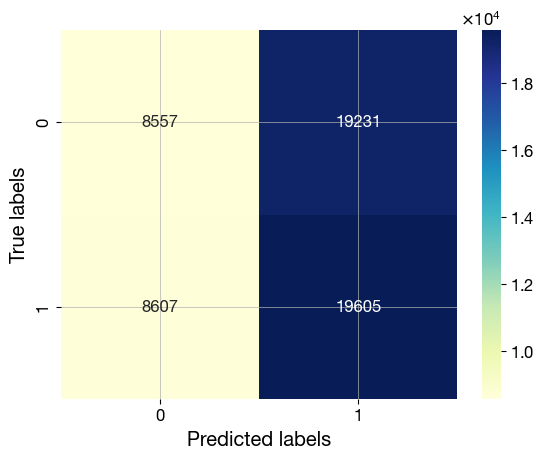

In [80]:
#Ploting the confusion matrix based on y
plot_confusion_matrix(y_test, y_pred)

- <font size =4> Classification Report

In [81]:
#Displaying The Classification report to find the F-score and Accuracy 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.50      0.31      0.38     27788
         1.0       0.50      0.69      0.58     28212

    accuracy                           0.50     56000
   macro avg       0.50      0.50      0.48     56000
weighted avg       0.50      0.50      0.48     56000



- <font size =4> AUC Curve

In [82]:
# Function purpose to plot the ROC curve
def plot_ROC_curve(fpr, tpr):
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [83]:
# Calculating the true positve and false positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred)

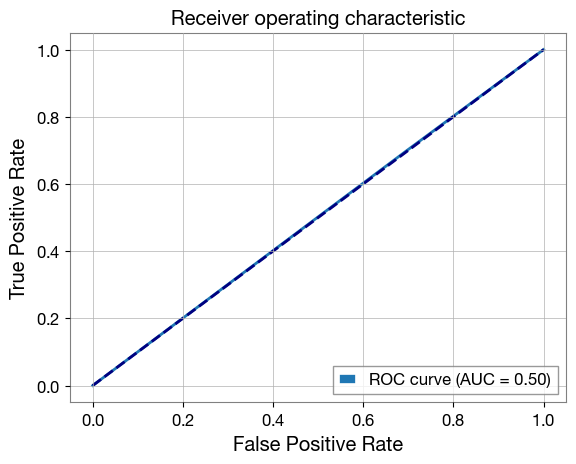

In [84]:
#Plotting the ROC Curve
plot_ROC_curve(fpr, tpr)